<h1>Fitting Thomson Scattering Data with GPR</h1>

The gpfit module in UNBAFFELD is designed to easily fit experimental Thomson scattering data regardless of tokamak operational regime. One must simply provide density/temperature data and a psi axis.

<h2>Generate Thomson data</h2>

To demonstrate its use, we first generate synthetic Thomson scattering data. This step is unnecessary if you have your own Thomson data you wish to fit.

In [88]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../workflow")
from syndata import efitAiData
sys.path.append("../")
from gpfit import GPTSFit

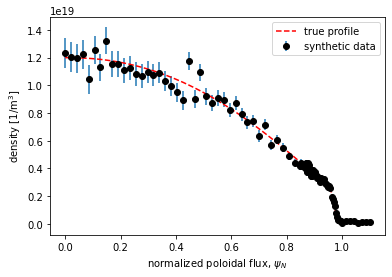

In [89]:
# generate hmode data
myprof = efitAiData("../workflow/hmode.yml")
myprof.add_syndata()
myprof.add_outliers()
norm = 1e18
myprof.profile *= norm
x = myprof.r
N = len(x)

# generate noise with specific error function to test fitting with experimental error
yerr = (1.11-x)*norm #np.random.uniform(0.01,2.0,N)
y = np.zeros(N)
for i in range(N):
      y[i] = myprof.profile[i] + np.random.normal(0.0,yerr[i])

# plot synthetic data
plt.errorbar(x,y,yerr,marker='o',mfc='black',mec='black',linestyle='',label='synthetic data')
plt.plot(x,myprof.profile,'r--',label='true profile')
plt.xlabel(r'normalized poloidal flux, $\psi_N$')
plt.ylabel(r'density [1/m$^3$]')
plt.legend()
plt.show()

A heteroskedastic error is used above to demonstrate the capabilities of the GPR fitting algorithm. We do not require that the experimental error be the same on each data point, but instead the error can be provided as a numpy array with each value corresponding to the error on each y-data point.

<h2>Perform Fit</h2>

We create a GPTSFit object using the x, y, and yerr data (ie. the poloidal flux, the density or temperature, and the error on the density/temperature).  There are other options for which method should be used, whether outliers should be accounted for, gradient constraints on axis and at edge, and if plotting should be automated.

We plot the synthetic data, the best fit from GPR, and the 95% confidence interval for the fit.

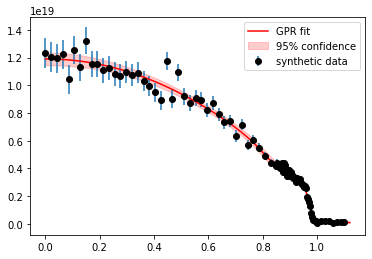

In [90]:
# perform fit
GPRfit = GPTSFit(x, y, yerr, method="EmpBayes", outlierMethod="None", plot=False)
mean,variance = GPRfit.performfit()
xx = GPRfit.X.flatten()

fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(x,y,yerr,marker='o',mfc='black',mec='black',linestyle='',label='synthetic data')
# plt.plot(x,y,'ko')
ax.plot(xx, mean, '-', color='red',label='GPR fit')
ax.fill_between(xx, mean - 2.*np.sqrt(variance), mean + 2.*np.sqrt(variance), color='red', alpha=0.2,label='95% confidence')
plt.legend()
plt.show()

Fitting using Gaussian Process Regression generates a multivariate normal distribution from which one can generate sample fits for the data points.  This is shown below, using the getSamples() method.  These are then plotted along with the best (mean) fit and the true profile from which the synthetic data were generated.

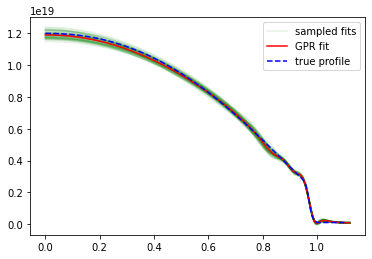

In [91]:
# draw 50 damples from the MVN
samples = GPRfit.getSamples(50)

# plot
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xx, samples[:,1:], 'g-', alpha=0.1)
ax.plot(xx,samples[:,0],'g-', alpha=0.1,label='sampled fits')
ax.plot(xx, mean, '-', color='red',label='GPR fit')
ax.plot(x,myprof.profile,'b--',label='true profile')
plt.legend()
plt.show()

**Pedestal Info**

Information about the pedestal is calculated using the fit and is accessible via the getPedestalInfo() method. This returns the location and the width of the pedestal in units of the x-axis, which in this case is $\psi_N$.

In [92]:
pedestal_width, pedestal_location = GPRfit.getPedestalInfo()
print("pedestal width: ",pedestal_width)
print("pedestal location: ",pedestal_location)

pedestal width:  0.9680402010050252
pedestal location:  0.009849246231155767
